In [1]:
import sys
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from plotly.plotly import iplot
import plotly.graph_objs as go
from IPython.display import Image
import plotly.offline as py
import pandas as pd
import numpy as np
import scipy as sp
import math
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve,classification_report
from sklearn import preprocessing
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, roc_curve, auc,recall_score,precision_score
from xgboost.sklearn import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')
py.init_notebook_mode(connected=True)
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

# Question 1
Suppose this data is a SQL table called ‘PokemonStats’. In an SQL dialect you are most comfortable with, find the top 3 Pokemon in terms of total stats of each type (primary type, Type_1). Your answer should include: 
 1. the SQL dialect you are using: T-sql 
 
 2. The SQL query used to answer this question; 
 
``` mysql
  SELECT I.Type_1, 
           I.Name, 
           I.Total
    FROM ( SELECT P.Type_1, 
                  P.Name, 
                  P.Total, 
                  ROW_NUMBER() OVER (PARTITION BY P.Type_1 ORDER BY P.Total DESC) as ranks
             FROM PokemonStats as P ) as I  
   WHERE I.ranks <= 3
ORDER BY I.Type_1, I.ranks; 
``` 
 3. The returned result: 
 
 (Top 6 rows)
 
I.Type_1 | I.Name | I.Total
------------- | -------------| -------------
Bug	| Genesect |600
Bug|Volcarona|550
Bug|Yanmega|515
Dark |Yveltal|	680
Dark|Darkrai	|600
Dark|Hydreigon	|600
|...|

# Question 2
Imagine a new Pokemon game where you are only allowed to collect ONE type of Pokemon. Similar to other Pokemon games, your goal is to have the strongest battlers and defenders for battles and raids. Which type will you pick? Why?

I will go with type "Rock". I start with lookiong at how many pokemons are in each type: 
<img src="output_9_0.png">

Since each battle we can rotate our pokemons to fight against our enemy, I won't consider type 'Flying'. Otherwise I will not jave enough team members within my team. Then I want to do narrow down more base on base attack and defense. By cheking the distribution them by each type, I can use the mean to represent the their stats since the distribution are mostly normal.  
<img src="output_10_0.png">
<img src="output_11_0.png">

After using 'mean' to represernt each group, I plotted them and shade the area theat having perfromance abovr average across the groups. Foour groups land into the above avrgare area: 
 - Steel / Rock / Ground / Dragon
<img src="output_14_0.png">

Now let's shift focus to these four groups. I want to include all other stats (include special attack, defense etc.), so I just compare the 'Total' stats by type. Yet, he total stats are not strongly difference.
<img src='test.png'>

If viewing their stats on a rador chart, it's clear that dragon has overall better performance in attack; steel, on the other hand, is strong at defense! So, why do I pick rock? 
<img src='rador.png'>

I want to dive deeper into individual pokemons's attack and defense power. Here it shows that in individual, type rock has pokemons the either **high attack** or **high defense**. Go back the the assumption that **we can rotate our pokemonds during the fight**, I can assign out-standing pokemons to fight against my enemy with strategy! As the graph states, the rock distributed evenly across the attack and defense axis, it's easier for me to have both attacker and defender in the team. To conclude, it's based on player's preference which type to go to. I personally like to have different charactors at my side! 
<img src='all_pkm_4_grp.png'>



# Question 3 
If you want to predict whether the Pokemon is a legendary Pokemon (a.k.a. predict the field isLegendary using other fields), which models would you use? List your top 3 models with pros and cons for each one.

After briefly look into the data, we can immediatly found that the data is imbalanced. Only 6% are legandery (I guess it makes sense becaues it's "legendary"). However, we aill need model that can actually address imbalance data. Further, the size of data is small. With only 721 rows of data, we won't able tp have a bunch to train on. To deal with imbalanced data, there are multiplel techniques we can apply on, one of it is toi choose proper algorithm that affet less by the negtive class. Decistion tree is usually better at this, so my top two are both tree based. Imbalanced data also imply that the model performance baseline should be 93% or above. 
Lets check the those legendary pokemons eyebally

<img src='output_27_1.png'>

1. **XGBOOST**: XGBoost is a gradient boosting Decision Trees model that esembles models which combine many weak models with stonger models. The model iterates the data multiple times and improves every run. Our model AUC is higher then our naive baseline 94%. Pros are it address imbalanced data by weighting and has high accuracy. But it's sensetive to the outliers and is also harder to optimize the parameters. The dark side of the accuracy it's could overfit if the number of trees are big. This is also the model I pick to implement (Q4-2). Here I'm using AUC instead of accuracy(99%) to evaluate the model. Due to imbalanced data, using accuracy will leads to accuracy paradox. On the other hand, AUC measures how true positive rate (recall) and false positive rate trade off, and show the are under ROC curve. 
<h3><center>AUC = 0.9710059171597631</center></h3>

2. Random Forest: Managed imbalanced data well and super easy to implement, Cons are sensetive to the noise, and not dealing with a large number of categories in categorical variables well. 
3. Naive Bayes: It can handle small dataset, and the algorithm of it is generally easir to interpret. However the fit tends to be lower compare with other models; assume the variables are indepedent to each other wich is rarely true in real world too.

# Question 4
Pick one model and implement it in a language you are most comfortable with (preferably Python or R). Please do not use the ‘Catch_Rate’ field (if you are Pokemon fan you know why :). What is your in-sample classification accuracy and what fields did you end up using?
Your answer should include: 
1. The code of implementing the model (incl. feature processing, model fitting and cross validating); 
2. The formula/description of your final model along with the accuracy number.
3. In addition to the code and the model specification, if you choose to submit a presentation/ dashboard as part of your writeup, you can present your results in any way you like.

# Legendary Prediction

In [43]:
# Import the table, rename the fields
DT = pd.read_csv('pokemon_data_science_(2).csv')
DT = DT.rename(columns = {"Type_1": "Type", 
                          "Type_2":"Sub_type"})
df = DT.copy()
df.head(3)

,Number,Name,Type,Sub_type,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green,True,0.88,Monster,Grass,False,0.71,6.90,45,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green,True,0.88,Monster,Grass,False,0.99,13.00,45,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green,True,0.88,Monster,Grass,True,2.01,100.00,45,quadruped


In [44]:
# data validation: how did the NAN distributed. 
print(df.isna().sum())

Number                0
Name                  0
Type                  0
Sub_type            371
Total                 0
HP                    0
Attack                0
Defense               0
Sp_Atk                0
Sp_Def                0
Speed                 0
Generation            0
isLegendary           0
Color                 0
hasGender             0
Pr_Male              77
Egg_Group_1           0
Egg_Group_2         530
hasMegaEvolution      0
Height_m              0
Weight_kg             0
Catch_Rate            0
Body_Style            0
dtype: int64


In [45]:
# Observed the NAs
df[
    (df['Sub_type'].isna() ==True) & 
    (df['Pr_Male'].isna() ==True) &  
    (df['Egg_Group_2'].isna() ==True)].head()

,Number,Name,Type,Sub_type,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
99,100,Voltorb,Electric,NaN,330,40,30,50,55,55,100,1,False,Red,False,nan,Mineral,NaN,False,0.51,10.40,190,head_only
100,101,Electrode,Electric,NaN,480,60,50,70,80,80,140,1,False,Red,False,nan,Mineral,NaN,False,1.19,66.60,60,head_only
119,120,Staryu,Water,NaN,340,30,45,55,70,55,85,1,False,Brown,False,nan,Water_3,NaN,False,0.79,34.50,225,head_base
131,132,Ditto,Normal,NaN,288,48,48,48,48,48,48,1,False,Purple,False,nan,Ditto,NaN,False,0.30,4.00,35,head_only
136,137,Porygon,Normal,NaN,395,65,60,70,85,75,40,1,False,Pink,False,nan,Mineral,NaN,False,0.79,36.50,45,head_legs


sub type and egg group (2) are just values missed by random since they simply don't have. In this case, 'Not Having a type'IS ALSO A TYPE. NAs of Probability of male is directly led by has gender or not. It's also meaningful as categorical data so we will impute it too.

In [46]:
# Replace NA values as a level
df['Egg_Group_2'] = df['Egg_Group_2'].fillna('NONE')
df['Sub_type'] = df['Sub_type'].fillna('NONE')

# Dig into the 'Pr_Male' field, found it's actually not that many of levels. Thus, can easily transform into categorical. 
df = df.replace({'Pr_Male' : { 1.0 : 'H-1', 0.875 : 'G.8', 0.75 : "F.7", 0.5: "E.5", 0.25: "C.2", 0.125:"B.1", 0: "A-0"}})
df["Pr_Male"] = df["Pr_Male"].fillna("NG")

# Flag the legendary
df['leg'] = np.where(df['isLegendary'] == True, 1, 0)

# Confirm we are not having any missing values
print(df.isna().sum())

Number              0
Name                0
Type                0
Sub_type            0
Total               0
HP                  0
Attack              0
Defense             0
Sp_Atk              0
Sp_Def              0
Speed               0
Generation          0
isLegendary         0
Color               0
hasGender           0
Pr_Male             0
Egg_Group_1         0
Egg_Group_2         0
hasMegaEvolution    0
Height_m            0
Weight_kg           0
Catch_Rate          0
Body_Style          0
leg                 0
dtype: int64


In [47]:
# Start exploratory as our interest of "Legendary"
dfg = df.groupby('isLegendary', as_index = False).count()
print(round((dfg.Number[1] / dfg.Number.sum())*100.00,1), '% of Pokemons are Legendary.')

6.4 % of Pokemons are Legendary.


Organize the columns: 
Categorical:
   - 'Type', 
   - 'Sub_type', 
   - 'Generation',
   - 'Color',
   - 'Egg_Group_1',
   - 'Egg_Group_2',
   - 'Body_Style',
   - 'Pr_Male' 

Numerical: 
   - 'Total', 
   - 'HP', 
   - 'Attack', 
   - 'Defense',
   - 'Sp_Atk', 
   - 'Sp_Def', 
   - 'Speed', 
   - 'Height_m', 
   - 'Weight_kg'

Binary:
   - 'hasGender',
   - 'hasMegaEvolution'

Predicting Target: 
   - 'isLegendary'

<Figure size 720x576 with 0 Axes>

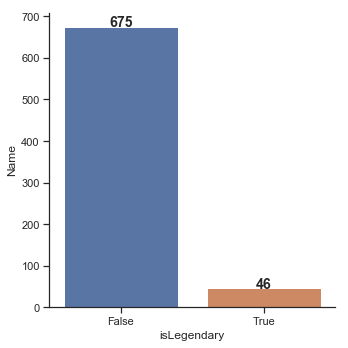

In [48]:
# Imbalanced data
plt.figure(figsize=(10, 8))
plot = sns.catplot(x="isLegendary", y="Name", kind = "bar", data=dfg)

for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, 
        h+10, 
        '{}'.format(int(h)),
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=14)

In [49]:
df[df.isLegendary == True]

,Number,Name,Type,Sub_type,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,leg
143,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True,Blue,False,NG,Undiscovered,NONE,False,1.70,55.40,3,two_wings,1
144,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True,Yellow,False,NG,Undiscovered,NONE,False,1.60,52.60,3,two_wings,1
145,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True,Yellow,False,NG,Undiscovered,NONE,False,2.01,60.00,3,two_wings,1
149,150,Mewtwo,Psychic,NONE,680,106,110,90,154,90,130,1,True,Purple,False,NG,Undiscovered,NONE,True,2.01,122.00,3,bipedal_tailed,1
242,243,Raikou,Electric,NONE,580,90,85,75,115,100,115,2,True,Yellow,False,NG,Undiscovered,NONE,False,1.91,178.00,3,quadruped,1
243,244,Entei,Fire,NONE,580,115,115,85,90,75,100,2,True,Brown,False,NG,Undiscovered,NONE,False,2.11,198.00,3,quadruped,1
244,245,Suicune,Water,NONE,580,100,75,115,90,115,85,2,True,Blue,False,NG,Undiscovered,NONE,False,2.01,187.00,3,quadruped,1
248,249,Lugia,Psychic,Flying,680,106,90,130,90,154,110,2,True,White,False,NG,Undiscovered,NONE,False,5.21,216.00,3,two_wings,1
249,250,Ho-Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,Red,False,NG,Undiscovered,NONE,False,3.81,199.00,3,two_wings,1
376,377,Regirock,Rock,NONE,580,80,100,200,50,100,50,3,True,Brown,False,NG,Undiscovered,NONE,False,1.70,230.00,3,bipedal_tailless,1


Eyebally scan through all this fields, we found couple fields show certain level in that field took over the most of the values - **Egg_Group_1**. 

In [50]:
df.groupby(['isLegendary','Egg_Group_1']).size()

isLegendary  Egg_Group_1 
False        Amorphous        41
             Bug              66
             Ditto             1
             Dragon           10
             Fairy            30
             Field           169
             Flying           44
             Grass            27
             Human-Like       37
             Mineral          46
             Monster          74
             Undiscovered     27
             Water_1          74
             Water_2          15
             Water_3          14
True         Undiscovered     46
dtype: int64

Let's dig into Egg_Group_1. All the legendary pokemons have the "Undiscovered" Egg_group_1! 

In [51]:
df.groupby(['isLegendary','Egg_Group_2']).size()

isLegendary  Egg_Group_2
False        Amorphous        8
             Bug              2
             Dragon          35
             Fairy           17
             Field           31
             Flying           6
             Grass           32
             Human-Like      15
             Mineral          8
             Monster          1
             NONE           484
             Water_1         13
             Water_2          8
             Water_3         15
True         NONE            46
dtype: int64

All legendary pokemons don't have Egg_group_2 -- NONE. 

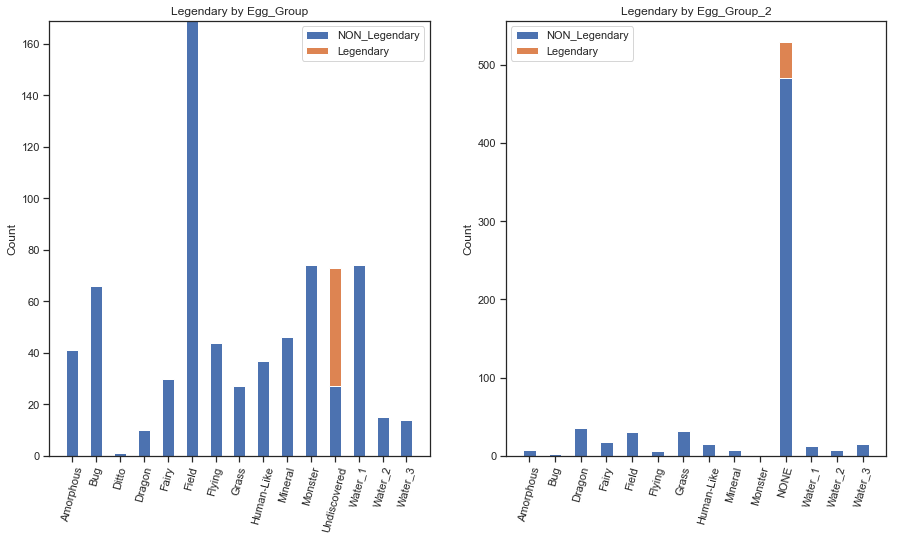

In [52]:
fig = plt.figure(figsize=(15, 8))
fig.add_subplot(121) 
grp = pd.DataFrame(df.groupby(['Egg_Group_1'])['leg'].sum())
grp['cnt'] = list(df.groupby(['Egg_Group_1'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by Egg_Group')
plt.xticks(ind, grp.index, rotation = 75)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))


fig.add_subplot(122)
grp = pd.DataFrame(df.groupby(['Egg_Group_2'])['leg'].sum())
grp['cnt'] = list(df.groupby(['Egg_Group_2'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by Egg_Group_2')
plt.xticks(ind, grp.index, rotation = 75)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))
plt.show()

**Charts clearly show that these two categorical fields will have good predicting power!**

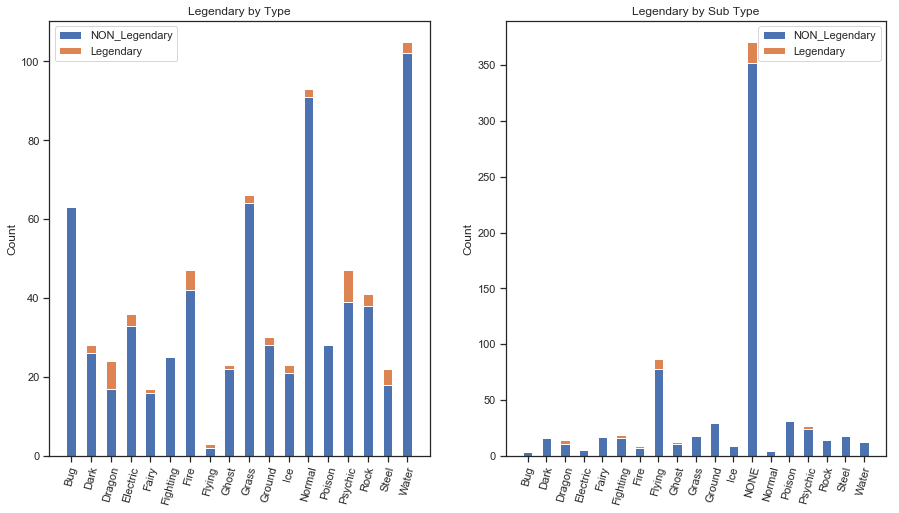

In [53]:
fig = plt.figure(figsize=(15, 8))
fig.add_subplot(121) 
grp = pd.DataFrame(df.groupby(['Type'])['leg'].sum())
grp['cnt'] = list(df.groupby(['Type'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by Type')
plt.xticks(ind, grp.index, rotation = 75)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))

fig.add_subplot(122) 
grp = pd.DataFrame(df.groupby(['Sub_type'])['leg'].sum())
grp['cnt'] = list(df.groupby(['Sub_type'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by Sub Type')
plt.xticks(ind, grp.index, rotation = 75)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))
plt.show()

HMMMM, other categorical filed dosen't have that much interactio with legendary or not though. Psychic and dragon seems to have more legendary pokemons, yet I think it's due to legendary pokemons usually have higher stats (and these are higher stat types). We will chart total's relationship with legendary later.



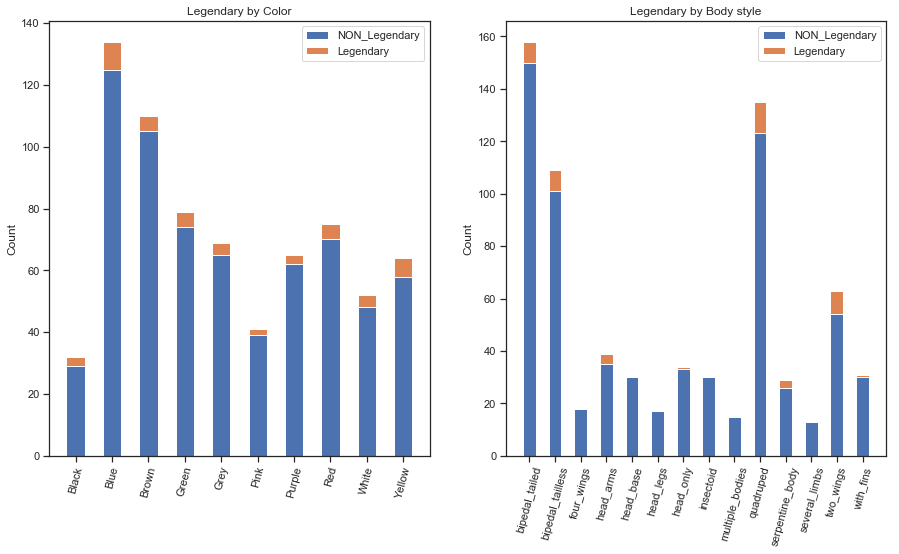

In [54]:
fig = plt.figure(figsize=(15, 8))
fig.add_subplot(121) 
grp = pd.DataFrame(df.groupby(['Color'])['leg'].sum())
grp['cnt'] = list(df.groupby(['Color'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by Color')
plt.xticks(ind, grp.index, rotation = 75)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))

fig.add_subplot(122) 
grp = pd.DataFrame(df.groupby(['Body_Style'])['leg'].sum())
grp['cnt'] = list(df.groupby(['Body_Style'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by Body style')
plt.xticks(ind, grp.index, rotation = 75)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))
plt.show()

Not surprisingly, color and body style do not have strong pattern.

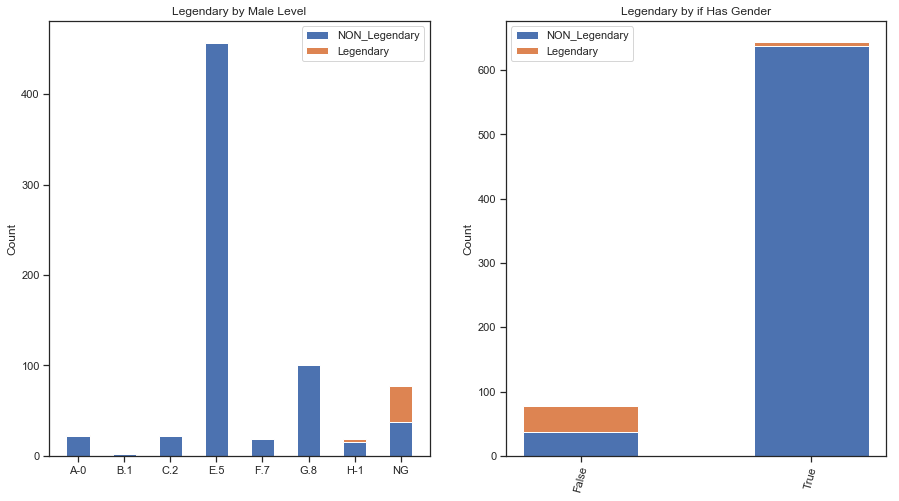

In [55]:
fig = plt.figure(figsize=(15, 8))
fig.add_subplot(121) 
grp = pd.DataFrame(df.groupby(['Pr_Male'])['leg'].sum())
grp['cnt'] = list(df.groupby(['Pr_Male'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by Male Level')
plt.xticks(ind, grp.index)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))


fig.add_subplot(122) 
grp = pd.DataFrame(df.groupby(['hasGender'])['leg'].sum())
grp['cnt'] = list(df.groupby(['hasGender'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by if Has Gender')
plt.xticks(ind, grp.index, rotation = 75)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))
plt.show()

Here has an interesting finding: **Legendary pokemons are usually No gender** 

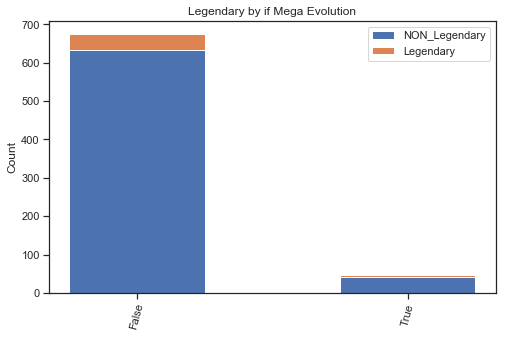

In [56]:
plt.figure(figsize=(8, 5))
grp = pd.DataFrame(df.groupby(['hasMegaEvolution'])['leg'].sum())
grp['cnt'] = list(df.groupby(['hasMegaEvolution'], as_index = False)['leg'].count().leg)
grp['N_leg'] = grp['cnt'] - grp['leg']
N = len(grp.index)
Legendary = grp['leg']
Non_legendary = grp['N_leg']
ind = np.arange(N)    
width = 0.5      
p1 = plt.bar(ind, Non_legendary, width)
p2 = plt.bar(ind, Legendary, width,
             bottom=Non_legendary)
plt.ylabel('Count')
plt.title('Legendary by if Mega Evolution')
plt.xticks(ind, grp.index, rotation = 75)
plt.legend((p1[0], p2[0]), ('NON_Legendary', 'Legendary'))
plt.show()

Not really seeing a pattern. 

In [57]:
# df_num = df[['Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Height_m', 'Weight_kg','isLegendary']]
# df_num.head()

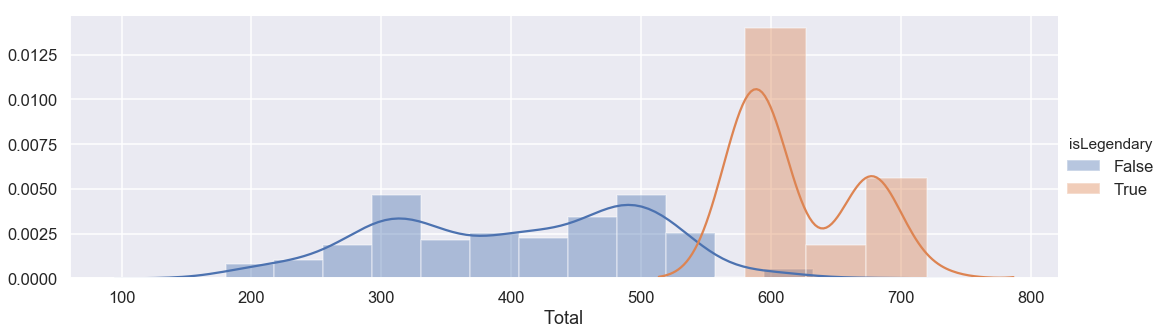

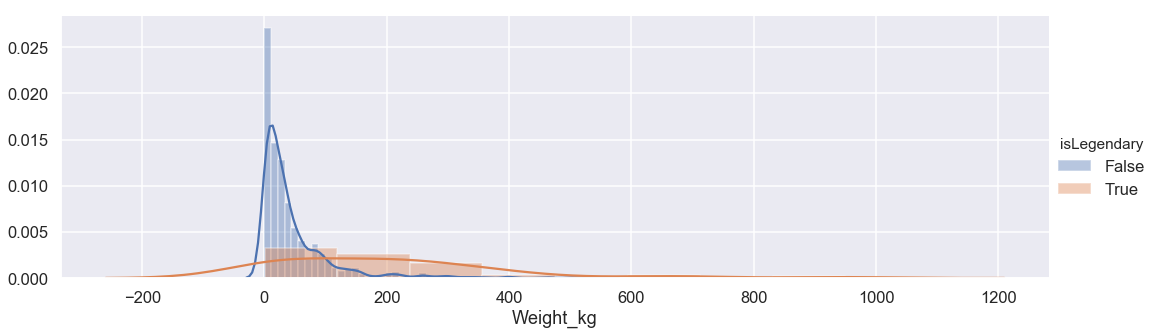

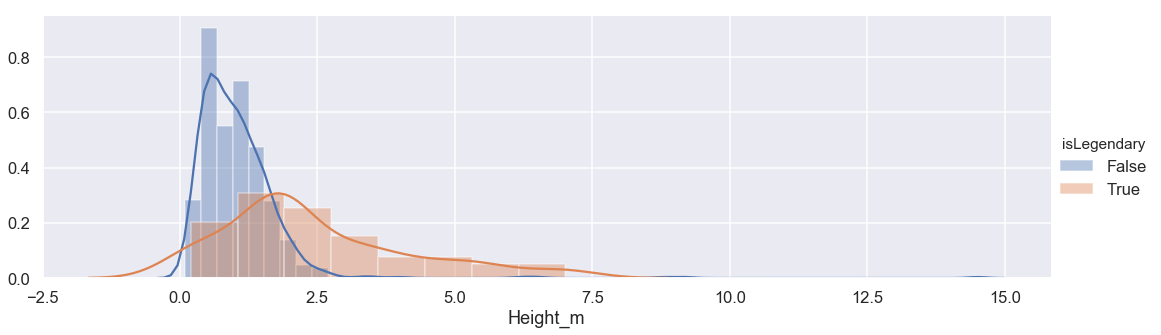

In [58]:
# Plot the relationship between numerical data: 
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')

grid = sns.FacetGrid(df,
                     hue='isLegendary',height=5, aspect=3)
grid.map(sns.distplot, 'Total')
grid.add_legend()

grid = sns.FacetGrid(df,
                     hue='isLegendary',height=5, aspect=3)
grid.map(sns.distplot, 'Weight_kg')
grid.add_legend()

grid = sns.FacetGrid(df,
                     hue='isLegendary',height=5, aspect=3)
grid.map(sns.distplot, 'Height_m')
grid.add_legend()

Total is a good indicator since the distributions of legendary and non-legendary are far from each other. However, legendary pokemon's weight and height's range are big, covered the whole X-axis with little predicting power.

In [59]:
df.head()

,Number,Name,Type,Sub_type,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,leg
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green,True,G.8,Monster,Grass,False,0.71,6.90,45,quadruped,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green,True,G.8,Monster,Grass,False,0.99,13.00,45,quadruped,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green,True,G.8,Monster,Grass,True,2.01,100.00,45,quadruped,0
3,4,Charmander,Fire,NONE,309,39,52,43,60,50,65,1,False,Red,True,G.8,Monster,Dragon,False,0.61,8.50,45,bipedal_tailed,0
4,5,Charmeleon,Fire,NONE,405,58,64,58,80,65,80,1,False,Red,True,G.8,Monster,Dragon,False,1.09,19.00,45,bipedal_tailed,0


In [60]:
X = df.copy()
np.random.seed(5)
Y = X['leg']
del X['leg']

            # Not including identifiers
X = X.drop(['Name','Number',
            # Only use 'Total' stat in our model because all stats variables are correlated 
            'HP', 'Attack', 'Defense','Sp_Atk', 'Sp_Def', 'Speed',  
            # Could be fully represented by Pr_male
            'hasGender',
            # Company generation / assigned values
            'Generation', 'Catch_Rate', 
            # Target Variable
            'isLegendary', 
            # Not seeing strong pattern 
            'Color', 'Height_m', 'Weight_kg', 'Body_Style', 'hasMegaEvolution'
            ],axis=1)

X.head()

,Type,Sub_type,Total,Pr_Male,Egg_Group_1,Egg_Group_2
0,Grass,Poison,318,G.8,Monster,Grass
1,Grass,Poison,405,G.8,Monster,Grass
2,Grass,Poison,525,G.8,Monster,Grass
3,Fire,NONE,309,G.8,Monster,Dragon
4,Fire,NONE,405,G.8,Monster,Dragon


In [61]:
# Feature engineering 
X['e1_undiscovered'] = np.where(X['Egg_Group_1']=="Undiscovered", 1, 0)
X['e2_none'] = np.where(X['Egg_Group_2']=="NONE", 1, 0)

In [62]:
X = X.drop(['Egg_Group_1','Egg_Group_2', 'Sub_type'], axis = 1)

In [63]:
# Using 0/1 flags to replace string false & true
X = X.replace({True :1, False:0})

# Binary all the categorical variables
X = pd.get_dummies(X, columns = ["Type" 
                                 #,"Sub_type"
                                 ,"Pr_Male"
                                 #,"Egg_Group_1"
                                 #,"Egg_Group_2"
                                ], drop_first = True)

In [64]:
# Split the dataset
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.33, random_state = 93)

# Add in weights to penalize the dominant class in the dataset
weights = ((Y == 0).sum() / (1.0 * (Y == 1).sum()))

# Model 
clf = XGBClassifier(max_depth = 8, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9710059171597631


In [65]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(testX)
predictions = [value for value in y_pred]
print('Accuracy = {}'.format(accuracy_score(testY, predictions)))
print(clf)

Accuracy = 0.9915966386554622
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=4, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=14.673913043478262, seed=None, silent=True,
              subsample=1)


Text(0.5,1,'Ordering of features by importance to the model learnt')

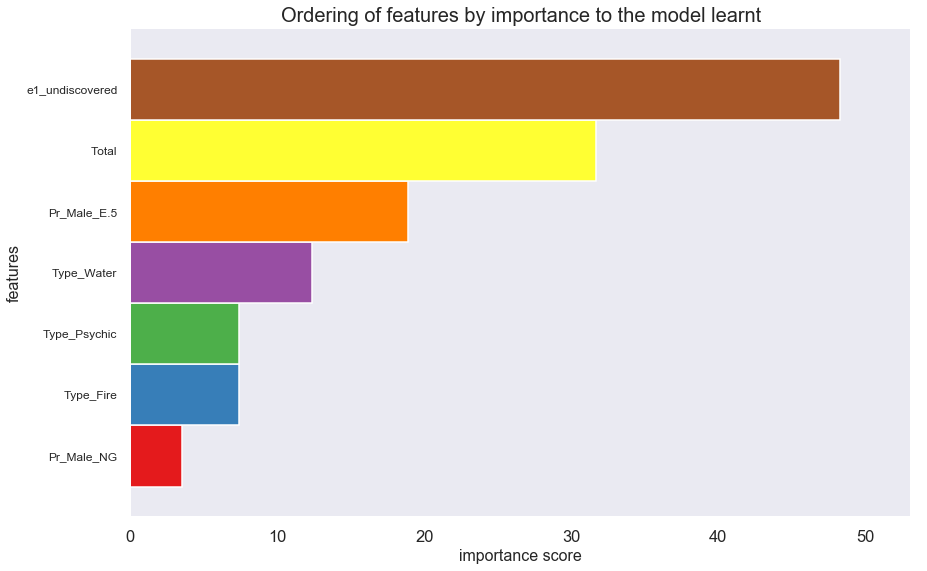

In [66]:
from xgboost import plot_importance
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



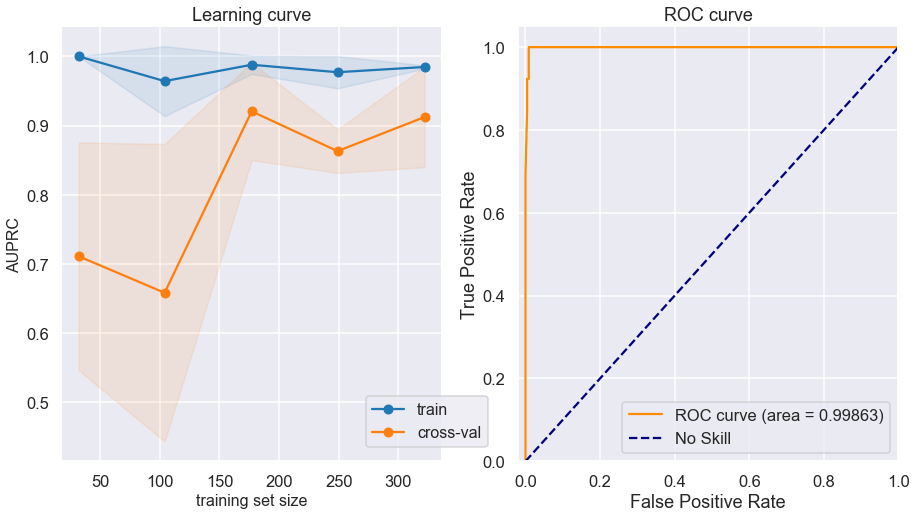

In [67]:
#######################################################################################################################
####### Learning Curve ################################################################################################
#######################################################################################################################
trainSizes, trainScores, crossValScores = learning_curve(clf, trainX, trainY, scoring = 'average_precision')

trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (15, 8))
fig.add_subplot(121)
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curve')

#######################################################################################################################
####### R O C #########################################################################################################
#######################################################################################################################

fpr, tpr, _ = roc_curve(testY.values, clf.fit(trainX, trainY).predict_proba(testX)[:,1])
roc_auc = auc(fpr, tpr)

fig.add_subplot(122) 
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',  label='No Skill')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Data Exploratory

In [27]:
# Reading in the dataset 
DT = pd.read_csv('pokemon_data_science_(2).csv')
print(DT.info())
DT.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 23 columns):
Number              721 non-null int64
Name                721 non-null object
Type_1              721 non-null object
Type_2              350 non-null object
Total               721 non-null int64
HP                  721 non-null int64
Attack              721 non-null int64
Defense             721 non-null int64
Sp_Atk              721 non-null int64
Sp_Def              721 non-null int64
Speed               721 non-null int64
Generation          721 non-null int64
isLegendary         721 non-null bool
Color               721 non-null object
hasGender           721 non-null bool
Pr_Male             644 non-null float64
Egg_Group_1         721 non-null object
Egg_Group_2         191 non-null object
hasMegaEvolution    721 non-null bool
Height_m            721 non-null float64
Weight_kg           721 non-null float64
Catch_Rate          721 non-null int64
Body_Style          721 non-

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green,True,0.88,Monster,Grass,False,0.71,6.90,45,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green,True,0.88,Monster,Grass,False,0.99,13.00,45,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green,True,0.88,Monster,Grass,True,2.01,100.00,45,quadruped
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,Red,True,0.88,Monster,Dragon,False,0.61,8.50,45,bipedal_tailed
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,Red,True,0.88,Monster,Dragon,False,1.09,19.00,45,bipedal_tailed
5,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False,Red,True,0.88,Monster,Dragon,True,1.70,90.50,45,bipedal_tailed
6,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False,Blue,True,0.88,Monster,Water_1,False,0.51,9.00,45,bipedal_tailed
7,8,Wartortle,Water,NaN,405,59,63,80,65,80,58,1,False,Blue,True,0.88,Monster,Water_1,False,0.99,22.50,45,bipedal_tailed
8,9,Blastoise,Water,NaN,530,79,83,100,85,105,78,1,False,Blue,True,0.88,Monster,Water_1,True,1.60,85.50,45,bipedal_tailed
9,10,Caterpie,Bug,NaN,195,45,30,35,20,20,45,1,False,Green,True,0.50,Bug,NaN,False,0.30,2.90,255,insectoid


In [28]:
# clean up, only take the fields I need to analysis
DT = DT.set_index('Number')
df = DT.iloc[:,0:10].copy().rename(columns = {"Type_1": "Type", 
                                              "Type_2":"Sub_type"})
df.head()

,Name,Type,Sub_type,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed
Number,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80
4,Charmander,Fire,NaN,309,39,52,43,60,50,65
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80


In [29]:
# Checking if the pokemons are unique 
print("Name of the Pokemon has no duplicate: ", len(df['Name'].unique()) == len(df['Name']))
# Checkin missing values
df.isna().sum(axis = 0) 

Name of the Pokemon has no duplicate:  True


Name          0
Type          0
Sub_type    371
Total         0
HP            0
Attack        0
Defense       0
Sp_Atk        0
Sp_Def        0
Speed         0
dtype: int64

In [30]:
# Based on 'Type', explotory the data
print(df.describe())

       Total     HP  Attack  Defense  Sp_Atk  Sp_Def  Speed
count 721.00 721.00  721.00   721.00  721.00  721.00 721.00
mean  417.95  68.38   75.01    70.81   68.74   69.29  65.71
std   109.66  25.85   28.98    29.30   28.79   27.02  27.28
min   180.00   1.00    5.00     5.00   10.00   20.00   5.00
25%   320.00  50.00   53.00    50.00   45.00   50.00  45.00
50%   424.00  65.00   74.00    65.00   65.00   65.00  65.00
75%   499.00  80.00   95.00    85.00   90.00   85.00  85.00
max   720.00 255.00  165.00   230.00  154.00  230.00 160.00


In [31]:
print(df['Type'].unique())
print(len(df['Type'].unique()))

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']
18


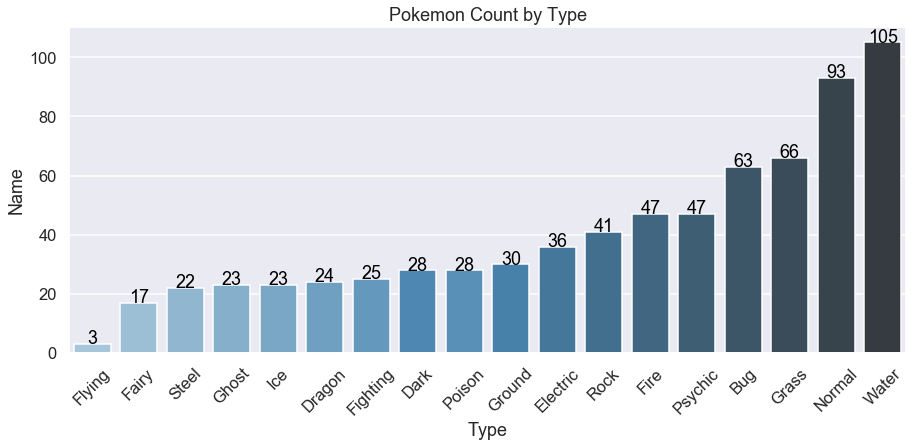

In [32]:
plt.figure(figsize=(15,6))

grp = pd.DataFrame(df.groupby('Type', as_index = False)['Name'].count())
grp = grp.sort_values(['Name']).reset_index(drop=True)

groupedvalues = grp
pal = sns.color_palette("Blues_d", len(groupedvalues))
rank = groupedvalues["Name"].argsort().argsort() 
g = sns.barplot(x='Type',y='Name',data=groupedvalues, palette=np.array(pal[::-1])[rank])

for index, row in groupedvalues.iterrows():
    g.text(row.name, row.Name, round(row.Name,2), color='black', ha="center")

g.set_title("Pokemon Count by Type")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

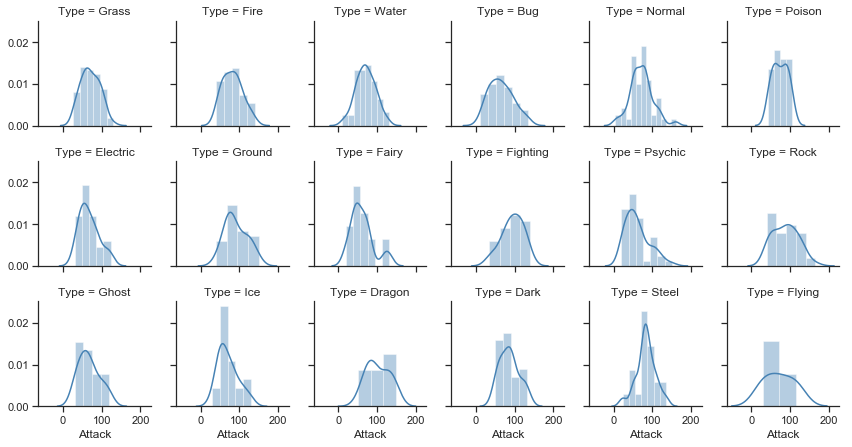

In [33]:
sns.set(style="ticks") 
g = sns.FacetGrid(df, col="Type", col_wrap=6, height=2 )
g.map(sns.distplot, "Attack", color="steelblue", kde = True)
plt.subplots_adjust(top=1)
plt.show()

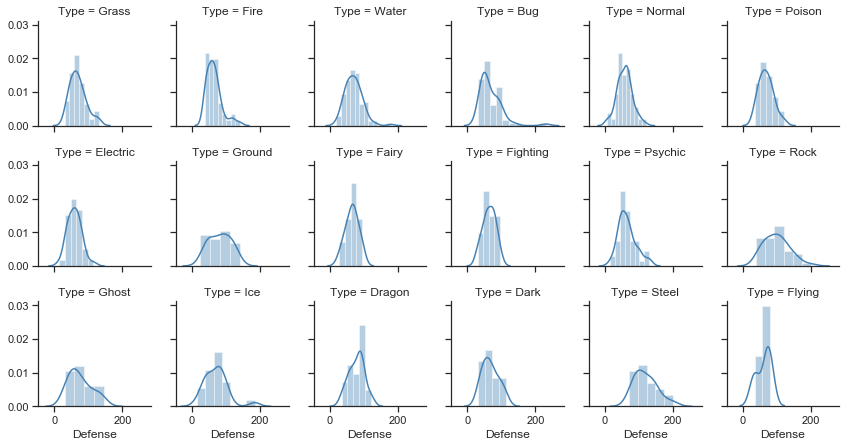

In [34]:
sns.set(style="ticks") 
g = sns.FacetGrid(df, col="Type", col_wrap=6, height=2 )
g.map(sns.distplot, "Defense", color="steelblue", kde = True)
plt.subplots_adjust(top=1)
plt.show()

In [35]:
grp = pd.DataFrame()
grp = pd.DataFrame(df.groupby('Type')['Name'].count().to_frame(name='count'))
grp['ATK_mean'] = pd.DataFrame(df.groupby('Type')['Attack'].mean()).values
grp['DFS_mean'] = pd.DataFrame(df.groupby('Type')['Defense'].mean()).values
grp['HP_mean'] = pd.DataFrame(df.groupby('Type')['HP'].mean()).values
grp['SP_ATK_mean'] = pd.DataFrame(df.groupby('Type')['Sp_Atk'].mean()).values
grp['SP_DFS_mean'] = pd.DataFrame(df.groupby('Type')['Sp_Def'].mean()).values

In [36]:
grp = grp.reset_index()
grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
Type           18 non-null object
count          18 non-null int64
ATK_mean       18 non-null float64
DFS_mean       18 non-null float64
HP_mean        18 non-null float64
SP_ATK_mean    18 non-null float64
SP_DFS_mean    18 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ KB


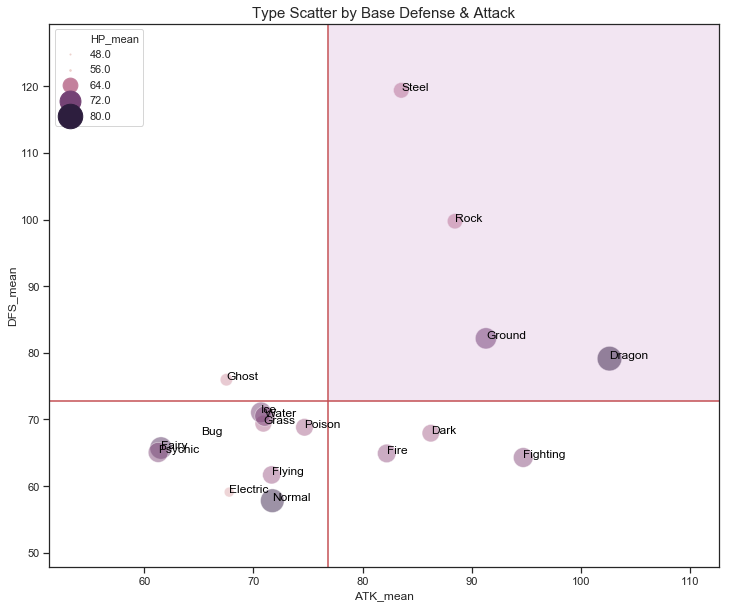

In [37]:
plt.figure(figsize=(12,10))

p1=sns.scatterplot(data=grp, 
                   x="ATK_mean", 
                   y="DFS_mean", 
                   size="HP_mean",
                   sizes=(1, 600),
                   alpha=0.5,
                   marker="o", 
                   hue= 'HP_mean')

for line in range(0, grp.shape[0]):
     p1.text(grp.ATK_mean[line], grp.DFS_mean[line], grp.Type[line], horizontalalignment='left', size='medium', color='black')
 
plt.axvline(grp["ATK_mean"].mean(), color='r')
plt.axhline(grp["DFS_mean"].mean(), color='r')

p1.set(ylim = (min(grp["DFS_mean"])-10, 
               max(grp["DFS_mean"]+10)), 
       xlim = (min(grp["ATK_mean"]-10), 
               max(grp["ATK_mean"]+10)))
       
p1.add_patch(
patches.Rectangle(
    (grp["ATK_mean"].mean(), grp["DFS_mean"].mean()), 
    (max(grp["ATK_mean"])+10) - grp["ATK_mean"].mean(), 
    (max(grp["DFS_mean"])+10) - grp["DFS_mean"].mean(), 
    alpha=0.1, 
    facecolor="purple")
)

#plt.title('Type Scatter by Base Defense & Attack', fontsize = 15)
p1.set_title('Type Scatter by Base Defense & Attack', fontsize = 15)
plt.show()

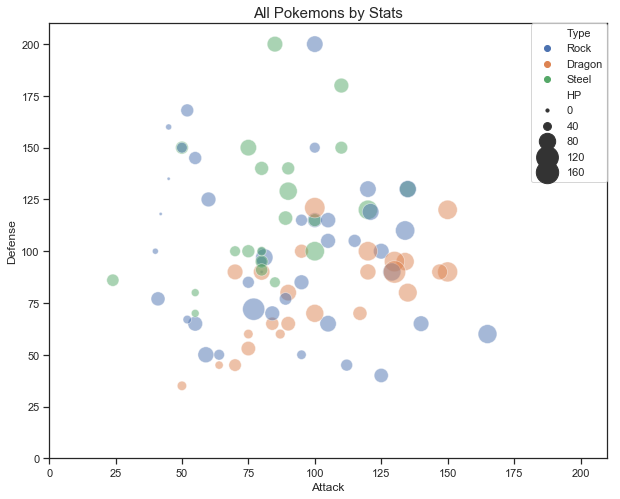

In [38]:
hgrp = df.loc[df['Type'].isin(['Dragon','Rock','Steel'])]
fig = plt.figure(figsize=(10,8))
plt.title('All Pokemons by Stats', fontsize = 15)
ax = sns.scatterplot(data = hgrp,
                      x="Attack", 
                      y="Defense", 
                      size = 'HP', 
                      sizes = (10, 500), 
                      alpha = 0.5,
                      hue="Type")
plt.ylim(0, 210)
plt.xlim(0, 210)
plt.setp(ax.get_legend().get_texts(), fontsize='8')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)

plt.savefig('all_pkm_4_grp.png')

In [39]:
#sns.set(style="ticks") 

#g = sns.FacetGrid(hgrp, col="Type", col_wrap=4, height=4)
#g.set(xlim = (-5,250), ylim = (0, 0.025))
#g.map(sns.distplot, "Attack", color="steelblue", kde = True)

#g = sns.FacetGrid(hgrp, col="Type", col_wrap=4, height=4)
#g.set(xlim = (-5,250), ylim = (0, 0.025))
#g.map(sns.distplot, "Defense", color="steelblue", kde = True)

#plt.show()

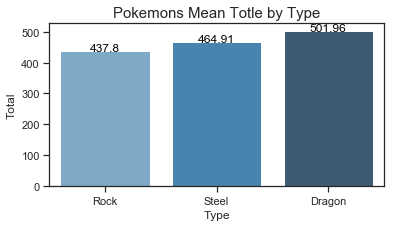

In [40]:
plt.figure(figsize=(6,3))

grp = pd.DataFrame(hgrp.groupby('Type', as_index = False)['Total'].mean())
grp = grp.sort_values(['Total']).reset_index(drop=True)

groupedvalues = grp
pal = sns.color_palette("Blues_d", len(groupedvalues))
rank = groupedvalues["Total"].argsort().argsort() 
g = sns.barplot(x='Type',y='Total',data=groupedvalues, palette=np.array(pal[::-1])[rank])

for index, row in groupedvalues.iterrows():
    g.text(row.name, row.Total, round(row.Total,2), color='black', ha="center")
    
g.set_title("Pokemons Mean Totle by Type" , fontsize = 15)
plt.savefig('test.png', bbox_inches='tight')
plt.show()


In [41]:
hgrp = df.loc[df['Type'].isin(['Dragon','Rock','Steel'])]
hgrp_mean = hgrp.groupby("Type", as_index = False).mean()
hgrp_mean

,Type,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed
0,Dragon,501.96,78.04,102.62,79.12,82.46,83.04,76.67
1,Rock,437.80,64.54,88.46,99.76,60.05,73.07,51.93
2,Steel,464.91,64.82,83.55,119.41,63.55,79.41,54.18


In [42]:
data = [
    go.Scatterpolar(
      r = list(hgrp_mean[hgrp_mean['Type'] == 'Dragon'].loc[0,'HP':'Speed'])+[hgrp_mean[hgrp_mean['Type'] == 'Dragon'].loc[0,'HP']],
      theta=['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'HP'],
      fill='toself',
      name = 'Dragon'
    ),
    go.Scatterpolar(
      r = list(hgrp_mean[hgrp_mean['Type'] == 'Steel'].loc[2,'HP':'Speed'])+[hgrp_mean[hgrp_mean['Type'] == 'Steel'].loc[2,'HP']],
      theta=['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'HP'],
      fill = 'toself',
      name = 'Steel'
    ),
      go.Scatterpolar(
      r = list(hgrp_mean[hgrp_mean['Type'] == 'Rock'].loc[1,'HP':'Speed'])+[hgrp_mean[hgrp_mean['Type'] == 'Rock'].loc[1,'HP']],
      theta=['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'HP'],
      fill = 'toself',
      name = 'Rock')
]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [1, 140]
    )
  ),
      
  showlegend = True,
  title = 'Steel V.S. Dragon V.S. Rock' 
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "radar/multiple")

Thank you :)